<a href="https://colab.research.google.com/github/Albertdofficial/CV/blob/main/Semantic_Segmentation_of_Road_Cracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
import torch
import albumentations as albu


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:

DATA_DIR = '/content/drive/My Drive/Colab Notebooks/RoadDataset/'
x_train_dir = os.path.join(DATA_DIR, 'XTrain')
y_train_dir = os.path.join(DATA_DIR, 'yTrain')

x_valid_dir = os.path.join(DATA_DIR, 'XVal')
y_valid_dir = os.path.join(DATA_DIR, 'yVal')

x_test_dir = os.path.join(DATA_DIR, 'XTest')
y_test_dir = os.path.join(DATA_DIR, 'yTest')

path, dirs, files = next(os.walk(y_train_dir))
file_count = len(files)
print(file_count)

625


In [4]:
CLASSES = ["crack", "no-crack"]


In [5]:
class Dataset(BaseDataset):
    """TrayDataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        # get images(x) and masks(y) ids
        self.ids_x = sorted(os.listdir(images_dir))
        # ['1001a01.jpg', '1005a.jpg', '1006a72.jpg', '2001a72.jpg', '2002a.jpg'] etc.
        self.ids_y = sorted(os.listdir(masks_dir))

        # get images(x) and masks(y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        # '/content/drive/My Drive/Colab Notebooks/TrayDataset/XTest/1001a01.jpg'
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        # The original line was causing the error because it was converting 'cls' to lowercase
        # but the elements in 'CLASSES' have the first letter capitalized.
        # self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        # The following line fixes the issue by comparing the lowercase version of elements in 'CLASSES'
        # to the lowercase version of 'cls'
        self.class_values = [CLASSES.index(cls) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids_x)

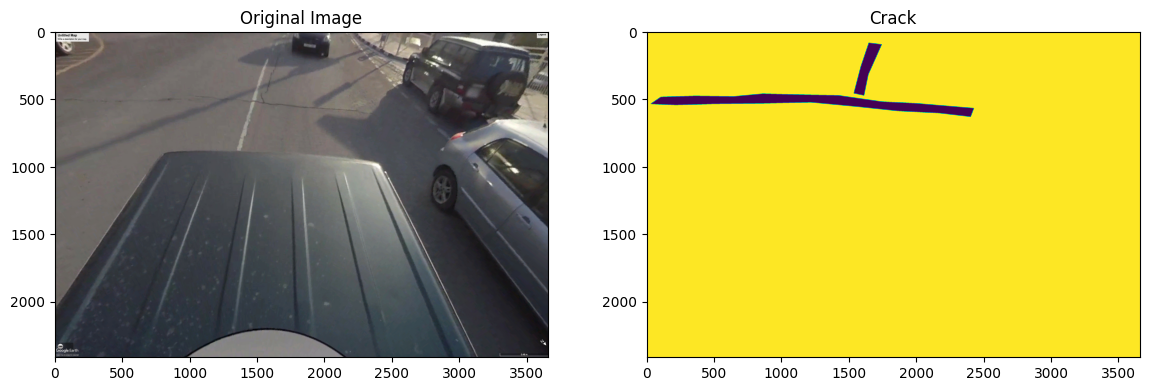

In [6]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Mask'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")


for label  in CLASSES:
  if label == 'crack':
      dataset = Dataset(x_test_dir, y_test_dir, classes=[label])
      image, mask = dataset[111]
      visualize(
          image=image, mask=mask.squeeze(),
          label  = label )

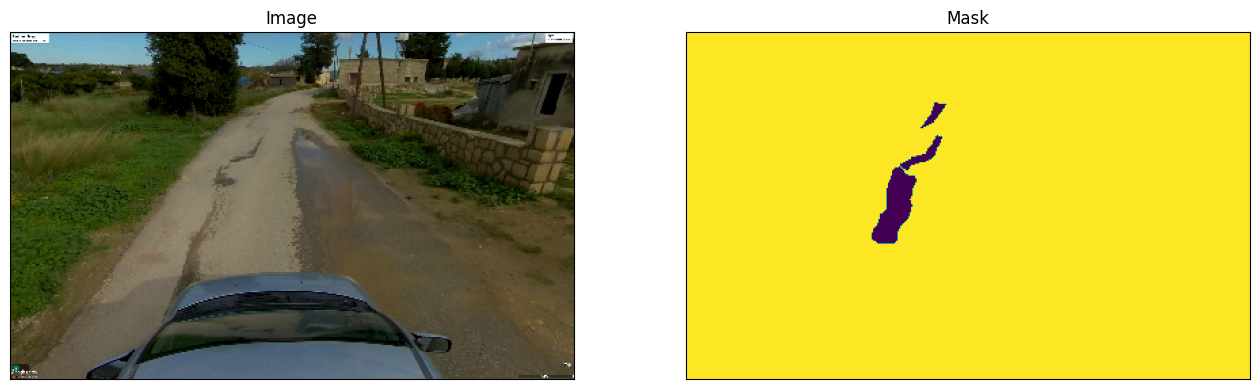

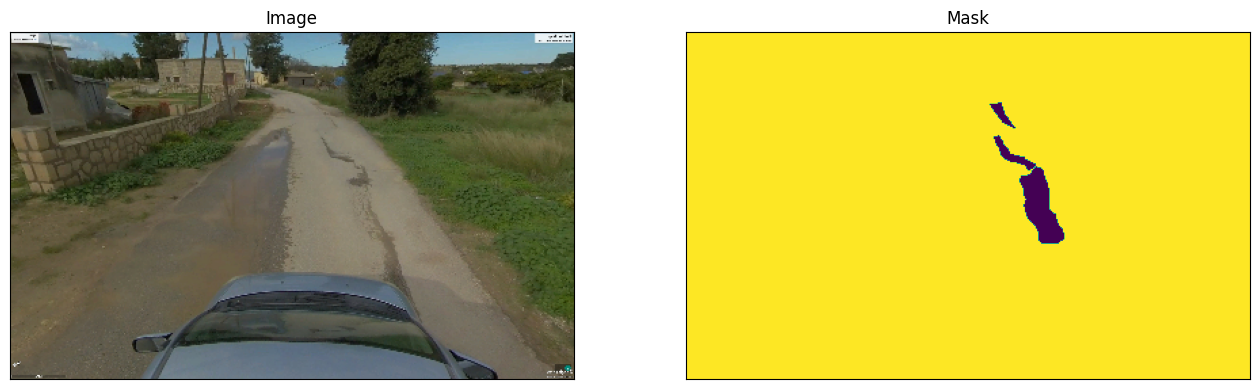

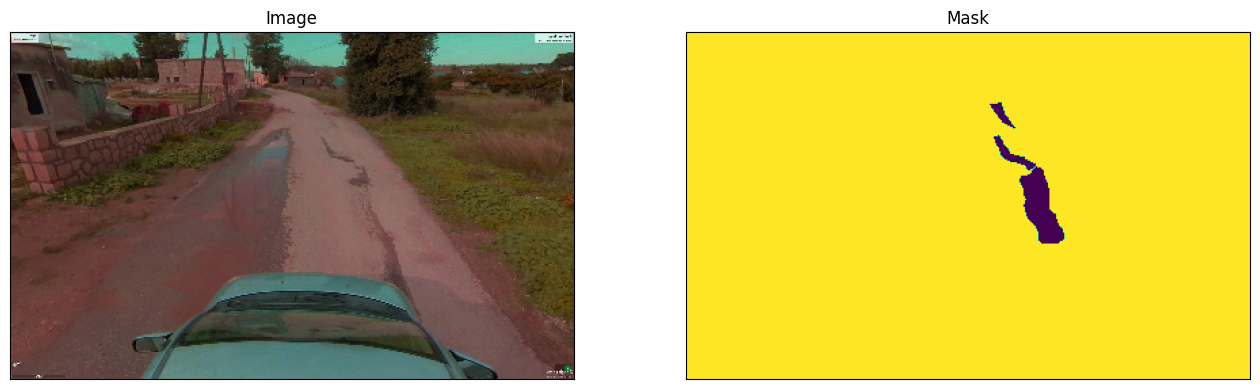

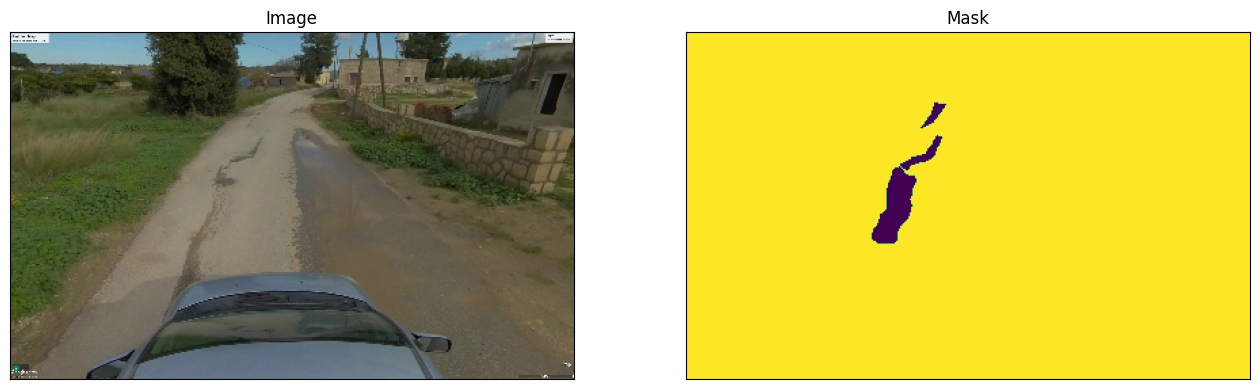

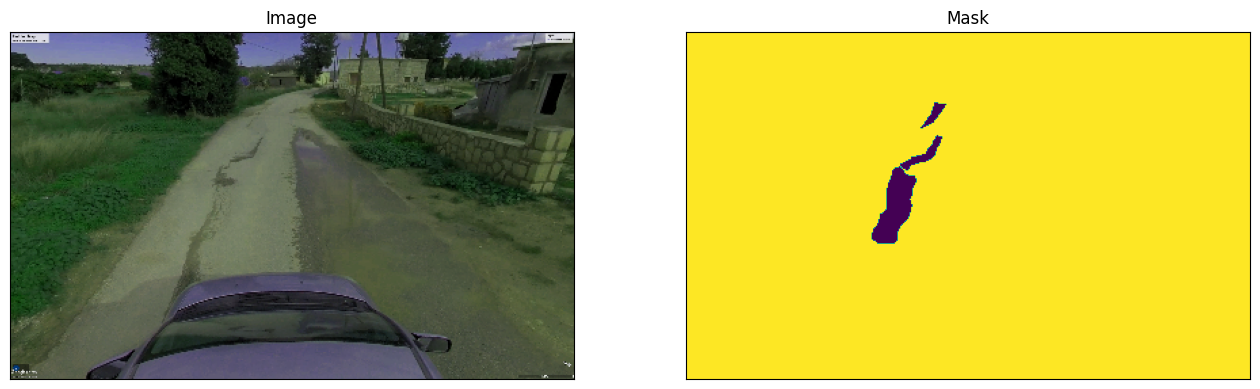

In [7]:
def get_training_augmentation():
    train_transform = [

        albu.Resize(256, 416, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.GaussNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 416)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


# helper function for data visualization
def visualizeData(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['crack'],
)

# same image with different  transforms
for i in range(5):
    image, mask = augmented_dataset[12]
    visualizeData(image=image, mask=mask.squeeze(-1))

In [12]:
# Create Dataset instances, specifying the classes argument
train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)  # Pass CLASSES here
val_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES)  # Pass CLASSES here
test_dataset = Dataset(x_test_dir, y_test_dir, classes=CLASSES)  # Pass CLASSES here

# Create DataLoader instances
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)  # Batch size of 1 for testing

In [9]:
import re
import torch.nn as nn


class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)
class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)

import torch


def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

import torch.nn as nn

class JaccardLoss(Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class L1Loss(nn.L1Loss, Loss):
    pass


class MSELoss(nn.MSELoss, Loss):
    pass


class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass


class NLLLoss(nn.NLLLoss, Loss):
    pass


class BCELoss(nn.BCELoss, Loss):
    pass


class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Fscore(Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Accuracy(Metric):
    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr,
            y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Recall(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return recall(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Precision(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

In [ ]:
#Install and Clone Github segmentation models pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [19]:
# Model Architecture

In [20]:
import torch
import segmentation_models_pytorch as smp

#resnext50_32x4d, mit_b2, timm-gernet_s, efficientnet-b3, mobilenet_v2, resnet152, vgg13
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

# create segmentation model with pretrained encoder
#Decoders= PAN, PSPNet, MAnet, Linknet, FPN, DeepLabV3, DeepLabV3Plus, Unetmsoe
model =smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
#Normalize your data the same way as during encoder weight pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


print(model)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
# Loss Function

In [11]:
#Define Optimization algorithm with Learning rate
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])


#Define Loss Function
loss = DiceLoss()

In [14]:
# Define Data Loaders

In [15]:
from torch.utils.data import DataLoader

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)


In [ ]:
# Model Training

In [16]:

"""**Model Training**"""

import numpy as np


class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [17]:
import sys
import torch
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction


In [18]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)




In [ ]:
# Training Loop

In [ ]:
max_score = 0

for i in range(0, 500):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Save the model with best iou score
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/UnetPlus.pth")
        print('Model saved!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


train:  38%|███▊      | 40/105 [13:33<22:14, 20.54s/it, dice_loss - 0.02491, iou_score - 0.9551, accuracy - 0.9769, fscore - 0.9762, recall - 0.9953, precision - 0.9583]